In [4]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision
from torchvision import transforms
import sys
import os, json, glob
from pathlib import Path
path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)
from utils import cv_from_binary

import pandas as pd
import numpy as np

In [5]:
for d in sorted(os.scandir(os.path.join('..','history')), key=lambda x:x.path, reverse=True):
    data_path = os.path.join(d.path, 'dataset.pkl')
    if os.path.exists(data_path):
        print(f'The most recent simulation folder has been selected "{d.path}":')
        df = pd.read_pickle(data_path)
        dataset = df.loc[~df['out_of_map'],['image','target_map']]
        dataset.head()
        break

The most recent simulation folder has been selected "../history/1205-002637":


In [6]:
df

,sensor,image,x,y,theta,ground_truth_odom_x,ground_truth_odom_y,ground_truth_odom_theta,run,out_of_map,target_map
time,,,,,,,,,,,
2020-12-04 23:26:39.487677108,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.211512,0.002449,0.007933,2.270681,9.947135,-2.916446,1,False,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
2020-12-04 23:26:39.610342124,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.226362,0.002564,0.007518,2.256210,9.943825,-2.916824,1,False,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
2020-12-04 23:26:39.728089117,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.241211,0.002672,0.007102,2.241737,9.940520,-2.917201,1,False,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
2020-12-04 23:26:39.853063883,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.256061,0.002775,0.006687,2.227263,9.937221,-2.917579,1,False,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
2020-12-04 23:26:39.979601239,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.270910,0.002871,0.006272,2.212787,9.933928,-2.917956,1,False,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-05 09:17:55.130332570,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",1754.008179,-692.656673,2.877333,10.055767,5.319260,0.449298,974,True,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
2020-12-05 09:17:55.248734094,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",1753.993850,-692.652793,2.876977,10.069135,5.325701,0.448966,974,True,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
2020-12-05 09:17:55.370205987,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",1753.965197,-692.645018,2.876265,10.082505,5.332138,0.448635,974,True,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."


## ML Dataset

In [7]:
def _moveaxis(tensor: torch.Tensor, source: int, destination: int) -> torch.Tensor:
    dim = tensor.dim()
    perm = list(range(dim))
    if destination < 0:
        destination += dim
    perm.pop(source)
    perm.insert(destination, source)
    return tensor.permute(*perm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 240, 320]) -2.0357141 1.9920369
Total data: 231818, train batches: 11519


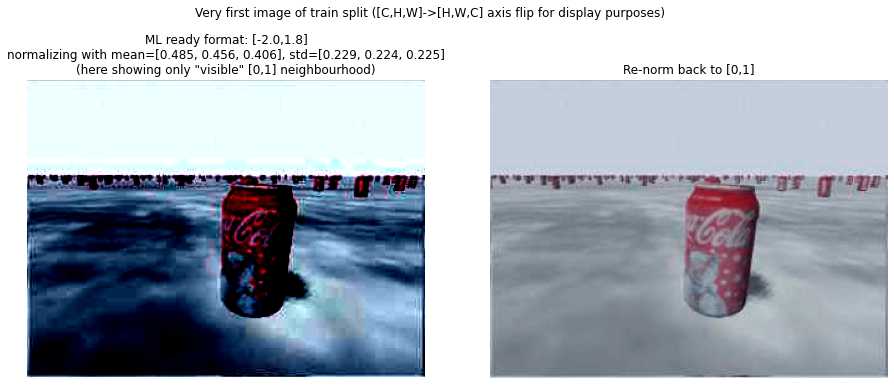

In [8]:
import torch
import matplotlib.pyplot as plt
def transform(x):
    x = cv_from_binary(x)
    # x = np.moveaxis(x,-1,0)
    
    # Images of shape (3 x H x W), where H and W are expected to be at least 224
    mobilenet_v2_format = transforms.Compose([
        #transforms.ToPILImage(), # Tensor of shape C x H x W or a numpy ndarray of shape H x W x C
        #transforms.Resize(256),transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return mobilenet_v2_format(x)

class ConvDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.X = images.values
        if labels is not None:
            labels = labels.map(lambda x: torch.as_tensor(x, dtype=torch.float32)).values
        self.y = labels
        self.transform = transform
         
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = self.X[i]
        
        if self.transform is not None:
            data = self.transform(data)
        
        if self.y is not None:
            return data, self.y[i]
        else:
            return data

cd = ConvDataset(dataset['image'], labels=dataset['target_map'], transform=transform)
train_val = [int(len(cd)*x) for x in [0.795,0.05]] # train, val
train_val_test = train_val + [len(cd)-sum(train_val)] # test
batch_size = 16
train_loader, val_loader, test_loader = [DataLoader(x, batch_size=batch_size, shuffle=True) for x in torch.utils.data.dataset.random_split(cd,train_val_test)]
fig, axs = plt.subplots(1,2, figsize=(13,5))
for X, y in train_loader:
    print(X.shape, X.numpy().min(), X.numpy().max())
    X = _moveaxis(X[0],0,-1)
    axs[0].imshow(X)
    axs[0].set_title(f'ML ready format: [{X.min():1.1f},{X.max():1.1f}]\nnormalizing with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]'+\
                     f'\n(here showing only "visible" [0,1] neighbourhood)')
    axs[0].axis('off')
    X = (X - X.min())/(X.max()-X.min())
    axs[1].imshow(X)
    axs[1].set_title(f'Re-norm back to [0,1]')
    axs[1].axis('off')
    plt.tight_layout()
    plt.suptitle('Very first image of train split ([C,H,W]->[H,W,C] axis flip for display purposes)', y=1.07)
    break
print(f'Total data: {len(cd)}, train batches: {len(train_loader)}')
plt.show()

# Models

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
models = {}

### Resnet18 Architechture

In [28]:
models['resnet18'] = torchvision.models.resnet18(num_classes=400)

### MobileNetv2 Architecture

In [29]:
model = torchvision.models.MobileNetV2(num_classes=400, 
                               inverted_residual_setting=[
                                    # t, c, n, s
                                    [1,  16, 1, 1],
                                    [6,  24, 2, 2],
                                    [6,  32, 3, 2],
                                    [6,  64, 4, 2],
                                    [6,  96, 3, 1],
                                    [6, 160, 3, 2],
                                    [6, 320, 1, 1],
                                ])
models['mobilenetv2'] = model

### Pretrained Resnet18 (frozen convolutional layers)

In [30]:
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
display(np.array(list(model._modules.keys())))
for k in model._modules.keys():
    if k != 'fc':
        for m in getattr(model, k).parameters():
            m.requires_grad = False
model.fc = nn.Linear(512, 400)
models['resnet18_pretrained'] = model

Using cache found in /Users/ste/.cache/torch/hub/pytorch_vision_master


array(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3',
       'layer4', 'avgpool', 'fc'], dtype='<U7')

### Pretrained MobileNetV2 (frozen convolutional layers)

In [31]:
import torch
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
model.to(device)
display(list(model._modules.keys()))
for param in model.features.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 400)
)
models['mobilenetv2_pretrained'] = model

Using cache found in /Users/ste/.cache/torch/hub/pytorch_vision_master


['features', 'classifier']

In [32]:
models.keys()

dict_keys(['resnet18', 'mobilenetv2', 'resnet18_pretrained', 'mobilenetv2_pretrained'])

# Chooose one

In [99]:
irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]
model = torchvision.models.MobileNetV2(num_classes=800, inverted_residual_setting=irs)

display(model.features[-2:], model.classifier)
model.features[-1][0].out_channels


Sequential(
  (7): InvertedResidual(
    (conv): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): ConvBNReLU(
        (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (2): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (8): ConvBNReLU(
    (0): Conv2d(96, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=800, bias=True)
)

1280

In [276]:
from bnn import nn as bnn_layers
from sklearn.metrics import roc_auc_score

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class conv_net(torchvision.models.MobileNetV2):
    def __init__(self, inverted_residual_setting, 
                 in_planes, out_planes, conv_bayes, 
                 num_classes, mode='', classifier_bayes=False,
                 width_mult = 1, round_nearest = 8,):
        
        # Call constructor to build most of the newtork
        super(conv_net, self).__init__(inverted_residual_setting=inverted_residual_setting, 
                                       width_mult=width_mult, round_nearest=round_nearest)
        
        # Redefine last convolutional block of the original architechture
        # In this way, we can control the output channels, they are the input channels of our extra convolution
        self.features[-1] = torchvision.models.mobilenet.ConvBNReLU(_make_divisible(inverted_residual_setting[-1][1] * width_mult, round_nearest),
                                       in_planes, kernel_size=1)
        
        # Whether we want a bayesian network or not, append the proper layer type to 'features'
        parameters = (in_planes, out_planes, 3, 1, 1)
        study_layer = nn.Conv2d(*parameters, bias=False)
        if conv_bayes:
            study_layer = bnn_layers.NormalConv2d(*parameters, bias=False)        
        self.features.add_module('extra', study_layer)
        
        # Redefine 'classifier' block at end of the network
        # In this way, we can control the input channels, they are the output channels of our extra convolution
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(out_planes, num_classes*2)
        )
           
        f = lambda x: x
        if mode == 'sigmoid':
            print('Logistic function has been appended (minimize MSE)')
            def f(x):
                x = nn.Sigmoid()(x)
                x = x.reshape(-1, 400, 2)
                return x
        elif mode == 'softmax':
            print('LogSoftmax function has been appended (minimize negative log-likelihood)')
            def f(x):
                x = x.reshape(-1, 400, 2)
                x = nn.LogSoftmax(dim=2)(x)
                return x
        self.final_touch = f
        
        print('Total model parameters:', sum(p.numel() for p in self.parameters()))
        #display(self.features[-3:], self.classifier)
        
    def forward(self, x):
        x = self._forward_impl(x)
        x = self.final_touch(x)
        return x

### Setup

In [279]:
#    t,  c, n, s
irs=[[1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 96, 1, 1]]

X, y = iter(train_loader).next()
stacked_y = torch.stack([1-y, y], dim=2)

for m in ['softmax','sigmoid']:
    
    model = conv_net(inverted_residual_setting=irs,                   # major part of the network
                     in_planes=200, out_planes=400, conv_bayes=False, # our extra convolution
                     num_classes=400, mode=m, classifier_bayes=False) # classifier parameters
    output = model(X)
    mask = (y > -1)
    
    if m == 'softmax':
        print(mask.shape)
        print('Model output:', list(output.shape), 'Desired:',list(y.shape))
        print('Masked output:', list(output[mask].shape), 'Masked desired:', list(y[mask].shape))
        print('Cross-entropy loss:', nn.NLLLoss()(output[mask], y.type(torch.LongTensor)[mask]).item())
        print('AUC:',roc_auc_score(stacked_y[mask], output[mask].detach().numpy()))
    else: # sigmoid
        print('MSE loss:', nn.MSELoss()(output[mask], stacked_y[mask]).item())
        print('AUC:',roc_auc_score(stacked_y[mask], output[mask].detach().numpy()))

LogSoftmax function has been appended (minimize negative log-likelihood)
Total model parameters: 1143152
torch.Size([16, 400])
Model output: [16, 400, 2] Desired: [16, 400]
Masked output: [365, 2] Masked desired: [365]
Cross-entropy loss: 0.6995090246200562
AUC: 0.5626839826839827
Logistic function has been appended (minimize MSE)
Total model parameters: 1143152
MSE loss: 0.24988120794296265
AUC: 0.619004329004329


#### Bayesian

In [13]:
from bnn import nn as bnn_layers
bnn_layers.NormalConv2d(32, 64, 3, 1)

NormalConv2d(
  (weight): WeightNormal()
  (bias): WeightNormal()
)

In [ ]:
import torchvision
model = torchvision.models.MobileNetV2(num_classes=400, 
                               inverted_residual_setting=[
                                    # t, c, n, s
                                    [1,  16, 1, 1],
                                    [6,  24, 2, 2],
                                    [6,  32, 3, 2],
                                    [6,  64, 2, 2],
                                    [6,  96, 1, 1]
                                ])


# Training, testing first

In [33]:
from sklearn.metrics import roc_auc_score
import torch.optim as optim




In [ ]:

# import torch.nn.functional as F

# # optimizer
# optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# # loss function
# criterion = nn.MSELoss(reduction='mean')


In [ ]:
# load sample batch
# data, target = iter(train_loader).next()
# mask = (target > -1)

# # get prediction
# output = model(data)

# # # compute auc
# auc = roc_auc_score(target[mask], output[mask].detach().numpy())
# display(auc)

# # masked loss
# loss = criterion(output[mask], target[mask])
# display(loss.item())

# # reset and comput gradient
# optimizer.zero_grad()
# loss.backward()

# # update network
# optimizer.step()

In [ ]:
epochs = 1

optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss(reduction='mean')

def get_loss_auc(X,y):
    mask = (y > -1)
    output = model(X)
    auc = roc_auc_score(y[mask], output[mask].detach().numpy())
    loss = criterion(output[mask], y[mask])
    return loss, auc

def show_progress(epoch, t, batch_idx, X, loader, loss, auc):
    print(f'\r{t} Epoch: {epoch + 1} [{batch_idx*len(X)}/{len(loader.dataset)} '+
                  f'({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}'+
                  f'\t\tAUC: {auc:.3f}', end='')

train_metrics = []
for epoch in range(epochs):
    model.train()
    try:
        for batch_idx, (X, y) in enumerate(train_loader):
            
            loss, auc = get_loss_auc(X, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_metrics.append([loss.item(), auc])
            
            show_progress(epoch, 'Training', batch_idx, X, train_loader, loss, auc)
            
#             if batch_idx % 1000:
#                 print()
#                 model.eval()
#                 with torch.no_grad():
#                     for batch_idy, (X, y) in enumerate(val_loader):
#                         loss, auc = get_loss_auc(X, y)
#                     show_progress(epoch, 'Validation', batch_idy, X, val_loader, loss, auc)
#                 model.train()
    except KeyboardInterrupt:
        #show_progress(epoch, 'End of training:', batch_idx, X, train_loader, loss, auc)
        print('\nUser stopped the training/validation phase')
    print()
    test_metrics = []
    model.eval() 
    try:
        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(test_loader):
                loss, auc = get_loss_auc(X, y)
                test_metrics.append([loss.item(), auc])
                show_progress(epoch, 'Test', batch_idx, X, test_loader, loss, auc)
    except KeyboardInterrupt:
        print('\nUser stopped the testing phase')
print('End of execution')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

def plot_metrics(model_name, train_metrics, test_metrics):
    fig, axs = plt.subplots(2,1,figsize=(10,8))
    def f(ax, metrics):
        df = pd.DataFrame(metrics, index=np.arange(0,len(metrics)*batch_size, batch_size), columns=['loss', 'auc'])
        ax.set_title('Training')
        ax.xaxis.set_major_locator(MultipleLocator(base=batch_size))
        sns.lineplot(data=df['loss'], ax=ax, label='Loss')
        ax.legend(loc=2)
        ax2 = ax.twinx()
        sns.lineplot(data=df['auc'], ax=ax2, color='C1', label='AUC')
        ax2.legend(loc=3)

    f(axs[0], train_metrics)
    f(axs[1], test_metrics)
    plt.suptitle(model_name)

plot_metrics('Pretrained MobileNetv2', train_metrics, test_metrics)

In [ ]:
import torch
model = torch.load('initial_test');

In [ ]:
#run_cd = ConvDataset(run['image'], labels=run['target_map'], transform=transform)
#run_loader = DataLoader(run_cd, batch_size=batch_size, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt, matplotlib.colors as clr
import seaborn as sns
fig, axs = plt.subplots(figsize=(6,6))
axs.axis('off')
X, y = cd[np.random.choice(len(cd))]
pred_omap = model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy()
def normalized_point(dist, x):
    near_one = dist.flat[np.abs(dist - x).argmin()]
    return (near_one - dist.min())/(dist.max()-dist.min())
cmap = clr.LinearSegmentedColormap.from_list('custom blue', [(0, 'white'), 
                                                             (normalized_point(pred_omap, -1), 'grey'),
                                                             (normalized_point(pred_omap, 0), 'green'), 
                                                             (normalized_point(pred_omap, 1),    'red'),
                                                             (normalized_point(pred_omap, +2), 'grey'),
                                                             (1, 'white')], N=256)
sns.heatmap(data=pred_omap, ax=axs, cmap=cmap, cbar=True)
plt.show()

In [ ]:
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [ ]:
ax.collections[0].__dict__.keys()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

user_input = 1
while user_input != '0':
    X, y = cd[np.random.choice(len(cd))]
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].imshow(_moveaxis(X, 0,-1))
    myColors = ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    sns.heatmap(data=y.reshape(20,20), ax=axs[1], cmap=cmap, cbar=False)
    
    
    cmap = clr.LinearSegmentedColormap.from_list('custom', ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0)), N=256)

    sns.heatmap(data=model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy(), ax=axs[2], cbar=False, cmap=cmap)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    user_input = input()

In [ ]:
import analyzer, importlib
importlib.reload(analyzer)
from IPython.display import Video
points_file = os.path.join(d.path, 'points.json')
with open(points_file) as f:
    points_d = json.load(f)
targets = np.array([(c['x'],c['y']) for c in points_d['targets']])

r = np.random.choice(df[~df['out_of_map']]['run'].unique())
run = df[df['run'] == r].copy()
save_path = os.path.join(d.path,'single_runs',f'omap_{r}.mp4')
analyzer.Animator(run, targets, rate=30, save_path=save_path, model=model)
display(Video(save_path))

In [ ]:
for X, y in torch.utils.data.DataLoader(test_loader, batch_size=1, num_workers=0, shuffle=True):
    fig, axs = plt.subplots(1,3, figsize=(20,5))
    axs[0].imshow(_moveaxis(X, 0,-1))
    sns.heatmap(data=y.reshape(20,20), ax=axs[1], cbar=False)
    sns.heatmap(data=model(X.unsqueeze(0)).squeeze().reshape(20,20).detach().numpy(), ax=axs[2], cbar=False)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    break